# ANIME RECOMMENDER SYSTEM

## Context

This data set which is taken from kaggle contains information on user preference data from 73,516 users on 12,294 anime. Each user is able to add anime to their completed list and give it a rating and this data set is a compilation of those ratings. The anime data and user ratings is provided by myanimelist.net API.

## Content

### Anime.csv

anime_id - myanimelist.net's unique id identifying an anime.

name - full name of anime.

genre - comma separated list of genres for this anime.

type - movie, TV, OVA, etc.

episodes - how many episodes in this show. (1 if movie).

rating - average rating out of 10 for this anime.

members - number of community members that are in this anime's "group".


### Rating.csv

user_id - non identifiable randomly generated user id.

anime_id - the anime that this user has rated.

rating - rating out of 10 this user has assigned (-1 if the user watched it but didn't assign a rating).

### Import libraries and load the dataset

In [151]:
import pandas as pd
import numpy as np
import math
import re
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import surprise
from surprise import Reader, Dataset, SVD, evaluate
sns.set_style("ticks")

In [152]:
ratings = pd.read_csv('rating.csv')
ratings.head(10)


,user_id,anime_id,rating
0,1,20,-1
1,1,24,-1
2,1,79,-1
3,1,226,-1
4,1,241,-1
5,1,355,-1
6,1,356,-1
7,1,442,-1
8,1,487,-1
9,1,846,-1


In [167]:
# checking for any null values
print("No of Nan values in our dataframe : ", sum(ratings.isnull().any()))

No of Nan values in our dataframe :  0


In [170]:
print("Total data ")
print("-"*50)
print("\nTotal no of ratings :",ratings.shape[0])
print("Total No of Users   :", len(np.unique(ratings.user_id)))
print("Total No of Anime  :", len(np.unique(ratings.anime_id)))

Total data 
--------------------------------------------------

Total no of ratings : 7813737
Total No of Users   : 73515
Total No of Anime  : 11200


### VISUALIZATION OF RATINGS

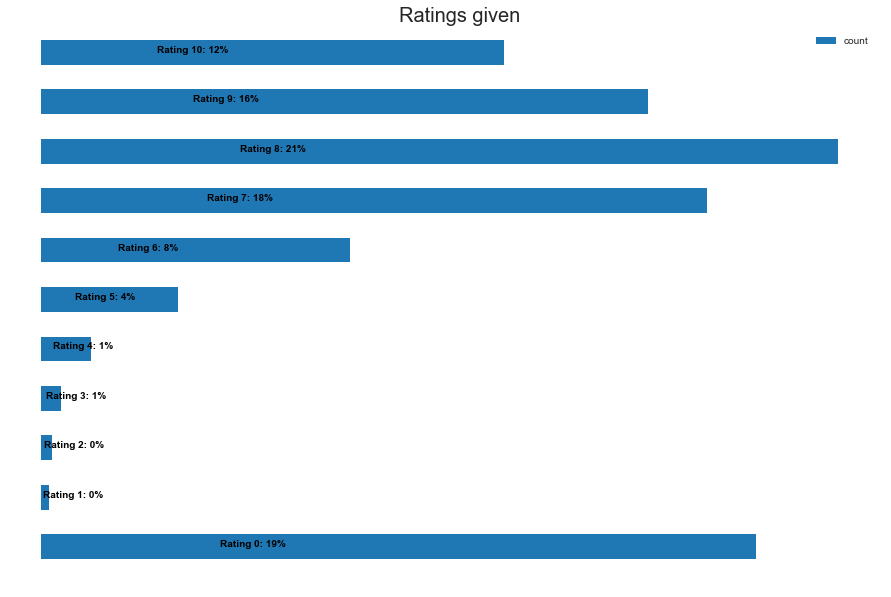

In [144]:

p = ratings.groupby('rating')['rating'].agg(['count'])
ax = p.plot(kind = 'barh', legend = True, figsize = (15,10))


plt.title('Ratings given',fontsize=20)
plt.axis('off')

for i in range(1,12):
    ax.text(p.iloc[i-1][0]/4, i-1, 'Rating {}: {:.0f}%'.format(i-1, p.iloc[i-1][0]*100 / p.sum()[0]), color = 'black', weight = 'bold')

In [153]:
#converting ratings from 1-5
ratings['rating'] = (ratings['rating'])/2
ratings.head()

,user_id,anime_id,rating
0,1,20,-0.5
1,1,24,-0.5
2,1,79,-0.5
3,1,226,-0.5
4,1,241,-0.5


In [173]:
ratings['rating'].describe()

count    7.813737e+06
mean     3.072015e+00
std      1.863900e+00
min     -5.000000e-01
25%      3.000000e+00
50%      3.500000e+00
75%      4.500000e+00
max      5.000000e+00
Name: rating, dtype: float64

### SLICING THE DATASET

In [2]:
#references: https://www.kaggle.com/laowingkin/netflix-movie-recommendation

In [154]:

f = ['count','mean']

anime_summary = ratings.groupby('anime_id')['rating'].agg(f)
anime_summary.index = anime_summary.index.map(int)
anime_min = round(anime_summary['count'].quantile(0.8),0)
drop_anime_list = anime_summary[anime_summary['count'] < anime_min].index

print('Minimum times of reviews for anime: {}'.format(anime_min))

df_cust_summary = ratings.groupby('user_id')['rating'].agg(f)
df_cust_summary.index = df_cust_summary.index.map(int)
cust_min = round(df_cust_summary['count'].quantile(0.8),0)
drop_cust_list = df_cust_summary[df_cust_summary['count'] < cust_min].index


print('Minimum times of reviews for a customer: {}'.format(cust_min))

Minimum times of reviews for anime: 634.0
Minimum times of reviews for a customer: 164.0


In [155]:
print('Original Shape: {}'.format(ratings.shape))
df = ratings[~ratings['anime_id'].isin(drop_anime_list)]
df = ratings[~ratings['user_id'].isin(drop_cust_list)]
print('After Trim Shape: {}'.format(df.shape))
print('-Data Examples-')
print(df.head())

Original Shape: (7813737, 3)
After Trim Shape: (4821593, 3)
-Data Examples-
     user_id  anime_id  rating
302        5         6     4.0
303        5        15     3.0
304        5        17     3.0
305        5        18     3.0
306        5        20     3.0


### LOAD THE ANIME DATASET

In [183]:
anime_data = pd.read_csv('anime.csv')

In [159]:
anime_data.head()

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266


In [161]:
anime_data.set_index('anime_id', inplace = True)
print (anime_data.head(10))

                                                       name  \
anime_id                                                      
32281                                        Kimi no Na wa.   
5114                       Fullmetal Alchemist: Brotherhood   
28977                                              Gintama°   
9253                                            Steins;Gate   
9969                                          Gintama&#039;   
32935     Haikyuu!!: Karasuno Koukou VS Shiratorizawa Ga...   
11061                                Hunter x Hunter (2011)   
820                                    Ginga Eiyuu Densetsu   
15335     Gintama Movie: Kanketsu-hen - Yorozuya yo Eien...   
15417                              Gintama&#039;: Enchousen   

                                                      genre   type episodes  \
anime_id                                                                      
32281                  Drama, Romance, School, Supernatural  Movie        1   
5114  

### WHAT USER 226 HAS WATCHED AND LIKED BEFORE:

In [162]:
n = 226
df_n = df[(df['user_id'] == n) & (df['rating'] >4)]
df_n = df_n.set_index('anime_id')
nm = anime_data['name']
df_n = df_n.join(nm)
print(df_n)

          user_id  rating                                               name
anime_id                                                                    
180           226     4.5                                           Vandread
181           226     4.5                         Vandread: The Second Stage
245           226     5.0                              Great Teacher Onizuka
269           226     5.0                                             Bleach
419           226     4.5                                Samurai Deeper Kyou
857           226     4.5                                           Air Gear
889           226     4.5                                       Black Lagoon
1067          226     4.5                       Kishin Houkou Demonbane (TV)
1127          226     4.5                              UFO Princess Valkyrie
1195          226     4.5                                   Zero no Tsukaima
1250          226     5.0                                    Erementar Gerad

### BUILD SVD MODEL USING TRAINSET

In [164]:
reader = Reader()
user_n = anime_data.copy()
user_n = user_n.reset_index()
user_n = user_n[~user_n['anime_id'].isin(drop_anime_list)]
svd = SVD()
# getting full dataset
data = Dataset.load_from_df(df[['user_id', 'anime_id', 'rating']], reader)

trainset = data.build_full_trainset()
model = svd.train(trainset)


C:\Users\Asus PC\Anaconda3\lib\site-packages\surprise\prediction_algorithms\algo_base.py:51: UserWarning: train() is deprecated. Use fit() instead
  warnings.warn('train() is deprecated. Use fit() instead', UserWarning)


### TOP 10 RECOMMENDATIONS FOR THE USER

In [165]:

user_n['Estimate_Score'] = df['anime_id'].apply(lambda x: svd.predict(n, x).est)

#user_n = user_n.drop('anime_id', axis = 1)

user_n = user_n.sort_values('Estimate_Score', ascending=False)
print(user_n.head(10))

       anime_id                                               name  \
2164       2847  Pokemon Diamond &amp; Pearl: Dialga vs. Palkia...   
3617       1760                                           Golgo 13   
4214      14093                      Pokemon Best Wishes! Season 2   
4688      31144                                          Mottainai   
11185      9311  Kateikyoushi no Oneesan 2 The Animation: H no ...   
1103      32365  Boruto: Naruto the Movie - Naruto ga Hokage ni...   
9418      16131            Machine Robo: Butchigiri Battle Hackers   
3808      31980                       Okusama ga Seitokaichou! OVA   
4208      32962                                      Occultic;Nine   
749       22125           Kuroko no Basket: Mou Ikkai Yarimasen ka   

                                                   genre     type episodes  \
2164     Action, Adventure, Comedy, Drama, Fantasy, Kids    Movie        1   
3617          Action, Adventure, Drama, Military, Seinen    Movie        

### USE TRAINSET AND TESTSET

In [174]:
from surprise import SVD
from surprise import Dataset
from surprise import accuracy
from surprise.model_selection import train_test_split


# sample random trainset and testset
# test set is made of 25% of the ratings.
trainset, testset = train_test_split(data, test_size=.25)

# We'll use the famous SVD algorithm.

# Train the algorithm on the trainset, and predict ratings for the testset
svd.fit(trainset)
predictions = svd.test(testset)

### EVALUATE RMSE AND MAE FOR SVD

In [176]:
print(accuracy.rmse(predictions))
print(accuracy.mae(predictions))

RMSE: 1.0878
1.0877919712104502
MAE:  0.7794
0.7794174683652741


### TOP-10 RECOMMENDATIONS FOR ALL USERS USING SVD

In [ ]:
from collections import defaultdict

from surprise import SVD
from surprise import Dataset

def get_top_n(predictions, n=10):

    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

top_n = get_top_n(predictions, n=10)

# Print the recommended items for each user
for uid, user_ratings in top_n.items():
    print(uid, [iid for (iid, _) in user_ratings])

### CALCULATE PRECISION AND RECALL

In [1]:
#references: https://surprise.readthedocs.io/en/stable/FAQ.html

In [32]:
from collections import defaultdict
from surprise import Dataset
from surprise import SVD
from surprise.model_selection import KFold

kf = KFold(n_splits=5)

def precision_recall_at_k(predictions, k=10, threshold=3.5):
    #Return precision and recall at k metrics for each user.
    # First map the predictions to each user.
    user_est_true = defaultdict(list)
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key=lambda x: x[0], reverse=True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        # Precision@K: Proportion of recommended items that are relevant
        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 1

        # Recall@K: Proportion of relevant items that are recommended
        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 1
    return precisions, recalls


for trainset, testset in kf.split(data):
    precisions, recalls = precision_recall_at_k(predictions, k=5, threshold=4)

    # Precision and recall can then be averaged over all users
print("Precision:", sum(prec for prec in precisions.values()) / len(precisions))
print("Recall:", sum(rec for rec in recalls.values()) / len(recalls))

Precision: 0.8991305230394231
Recall: 0.16636605881617858


### k- NEAREST NEIGHBOR ITEM BASED

In [177]:
import io 

from surprise import KNNBasic
from surprise import Dataset
from surprise import get_dataset_dir


sim_options = {'name': 'pearson', 'user_based': False}
knn = KNNBasic(sim_options=sim_options)
knn.fit(trainset)
predictions = knn.test(testset)


Computing the pearson similarity matrix...
Done computing similarity matrix.


In [178]:
print(accuracy.rmse(predictions))
print(accuracy.mae(predictions))

RMSE: 1.1845
1.1844714497331137
MAE:  0.8833
0.8832844551653122


### TOP-10 RECOMMENDATIONS

In [185]:
from surprise import Dataset
from surprise import get_dataset_dir

neighbors = knn.get_neighbors(0, k=10)
print()
print('The 10 nearest neighbors of Kimi no Na Wa are:')


for i in neighbors:
    for j in anime_data['anime_id']:
        if j== i:
            print(anime_data['name'][j])



The 10 nearest neighbors of Kimi no Na Wa are:
Code Geass: Hangyaku no Lelouch
Shokugeki no Souma
Ookami to Koushinryou II
Major S3
Natsume Yuujinchou: Itsuka Yuki no Hi ni
NHK ni Youkoso!
Shelter
InuYasha: Kanketsu-hen
One Piece Film: Gold


In [194]:
for trainset, testset in kf.split(data):
    precisions, recalls = precision_recall_at_k(predictions, k=10, threshold=4)

    # Precision and recall can then be averaged over all users
print("Precision:", sum(prec for prec in precisions.values()) / len(precisions))
print("Recall:", sum(rec for rec in recalls.values()) / len(recalls))

Precision: 0.9527133899773845
Recall: 0.13032166885177313


### k-NN BASELINE USING STOCHASTIC GRADIENT DESCENT 

In [187]:
import io 

from surprise import KNNBaseline
from surprise import Dataset
from surprise import get_dataset_dir


sim_options = {'name': 'pearson_baseline', 'user_based': False}
bsl_options = {'method': 'sgd',
               'learning_rate': .005,
               }
knn_b = KNNBaseline(bsl_options=bsl_options, sim_options=sim_options)
knn_b.fit(trainset)
predictions_b = knn_b.test(testset)


Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


In [188]:
print(accuracy.rmse(predictions_b))
print(accuracy.mae(predictions_b))

RMSE: 1.0803
1.0802914817857145
MAE:  0.7690
0.7690469968304519


### TOP-10 RECOMMENDATIONS

In [190]:
neighbors_b = knn_b.get_neighbors(0, k=10)
print()
print('The 10 nearest neighbors of Kimi no Na Wa are:')


for i in neighbors_b:
    for j in anime_data['anime_id']:
        if j== i:
            print(anime_data['name'][j])


The 10 nearest neighbors of Kimi no Na Wa are:
JoJo no Kimyou na Bouken: Stardust Crusaders
Aoki Hagane no Arpeggio: Ars Nova DC
Kara no Kyoukai 5: Mujun Rasen
Bleach Movie 1: Memories of Nobody
Detective Conan OVA 01: Conan vs. Kid vs. Yaiba
Durarara!!x2 Shou: Watashi no Kokoro wa Nabe Moyou
Sword Art Online: Extra Edition
Huyao Xiao Hongniang: Yue Hong
Slam Dunk


In [195]:
for trainset, testset in kf.split(data):
    precisions, recalls = precision_recall_at_k(predictions_b, k=5, threshold=4)

    # Precision and recall can then be averaged over all users
print("Precision:", sum(prec for prec in precisions.values()) / len(precisions))
print("Recall:", sum(rec for rec in recalls.values()) / len(recalls))

Precision: 0.932154859372506
Recall: 0.1539874206096337
